# Text Classification w/ <img src="https://raw.githubusercontent.com/madewithml/images/master/images/tensorflow.png" width="25rem"> TensorFlow

<div align="left">
<a href="https://github.com/madewithml/e2e-ml-app-tensorflow/blob/master/notebook.ipynb" role="button"><img class="notebook-badge-image" src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/madewithml/e2e-ml-app-tensorflow/blob/master/notebook.ipynb"><img class="notebook-badge-image" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

When building at end-to-end project, I often start with exploring the dataset and doing some basic modeling on a notebook first. The ability to execute code without having to rerun everything start to finish for every iterative change is great way to iterate quickly. 

→ Check out the full repo here: [e2e-ml-app-tensorflow](https://github.com/madewithml/e2e-ml-app-tensorflow)

In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf

## Set up

In [2]:
seed = 1234

In [3]:
# Set seeds for reproducibility
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

## Load data

In [4]:
data_size = 1.0 # use smaller sizes at the beginning to iterate quickly and catch errors
url = "https://raw.githubusercontent.com/madewithml/lessons/master/data/news.csv"

In [5]:
# Load data
df = pd.read_csv(url)
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,title,category
0,Sharon Accepts Plan to Reduce Gaza Army Operat...,World
1,Internet Key Battleground in Wildlife Crime Fight,Sci/Tech
2,July Durable Good Orders Rise 1.7 Percent,Business
3,Growing Signs of a Slowing on Wall Street,Business
4,The New Faces of Reality TV,World


In [6]:
# Reduce dataset
# You should always overfit your models on a small
# dataset first so you can catch errors quickly.
df = df[:int(len(df)*data_size)]
len(df)

120000

In [7]:
# Inputs and outputs
X = df['title'].values
y = df['category'].values
X, y

(array(['Sharon Accepts Plan to Reduce Gaza Army Operation, Haaretz Says',
        'Internet Key Battleground in Wildlife Crime Fight',
        'July Durable Good Orders Rise 1.7 Percent', ...,
        'Musharraf says U.S. must address root of terrorism (Reuters)',
        'Nuclear materials  #39;vanish #39; in Iraq',
        'In Brief: Bowstreet unveils pre-packaged portal offerings'],
       dtype=object),
 array(['World', 'Sci/Tech', 'Business', ..., 'World', 'World', 'Sci/Tech'],
       dtype=object))

# Preprocess


In [10]:
import re

In [11]:
def preprocess_texts(texts):
    preprocessed_texts = []
    for text in texts:
        # remove items text in () ex. (Reuters)
        # may want to refine to only remove if at end of text
        text = re.sub(r'\([^)]*\)', '', text)

        # spacing
        text = re.sub(r"([.,!?])", r" \1 ", text)
        text = re.sub(' +', ' ', text)  # remove multiple spaces
        text = text.strip()

        preprocessed_texts.append(text)
    return preprocessed_texts

In [12]:
# Preprocess (lowering/filtering is done later via TF tokenizer)
original_X = X
X = preprocess_texts(texts=X)
print ("Preprocessed data:\n" 
    f"  {original_X[0]} → {X[0]}")

Preprocessed data:
  Sharon Accepts Plan to Reduce Gaza Army Operation, Haaretz Says → Sharon Accepts Plan to Reduce Gaza Army Operation , Haaretz Says


## Split data

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
val_size = 0.15
test_size = 0.15
shuffle = True

In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split( # creating train and test
        X, y, test_size=test_size, stratify=y, shuffle=shuffle)
X_train, X_val, y_train, y_val = train_test_split( # creating train and val
    X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle)
print ("Data splits:\n"
        f"  X_train: {len(X_train)}, y_train: {len(y_train)}\n"
        f"  X_val: {len(X_val)}, y_val: {len(y_val)}\n"
        f"  X_test: {len(X_test)}, y_test: {len(y_test)}")

Data splits:
  X_train: 86700, y_train: 86700
  X_val: 15300, y_val: 15300
  X_test: 18000, y_test: 18000


## Tokenization

In [16]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer

In [17]:
filters = "[!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~]"
lower = True
char_level = False

In [18]:
# Tokenizer
X_tokenizer = Tokenizer(
    filters=filters, lower=lower, char_level=char_level, oov_token='<UNK>')
X_tokenizer.fit_on_texts(X_train)
vocab_size = len(X_tokenizer.word_index) + 1  # +1 for padding token
print (f"vocab_size: {vocab_size}")

vocab_size: 29794


In [19]:
# Convert texts to sequences of indices
original_text = X_train[0]
X_train = np.array(X_tokenizer.texts_to_sequences(X_train))
X_val = np.array(X_tokenizer.texts_to_sequences(X_val))
X_test = np.array(X_tokenizer.texts_to_sequences(X_test))
preprocessed_text = X_tokenizer.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (raw) {original_text}\n"
    f"  (preprocessed) {preprocessed_text}\n"
    f"  (tokenized) {X_train[0]}")

Text to indices:
  (raw) Fed , Corporate Forecasts to Set Tone
  (preprocessed) fed corporate forecasts to set tone
  (tokenized) [374, 1266, 1419, 2, 70, 4780]


## Label encoding

In [20]:
# Label encoder
y_tokenizer = LabelEncoder()
y_tokenizer = y_tokenizer.fit(y_train)
classes = y_tokenizer.classes_
print (f"classes: {classes}")

classes: ['Business' 'Sci/Tech' 'Sports' 'World']


In [21]:
# Convert labels to tokens
class_ = y_train[0]
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)
print ("Labels to indices:\n"
    f"  {class_} → {y_train[0]}")

Labels to indices:
  Business → 0


In [22]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print ("class counts:\n"
    f"  {counts}\n"
    "class weights:\n"
    f"  {class_weights}")

class counts:
  [21675 21675 21675 21675]
class weights:
  {0: 4.61361014994233e-05, 1: 4.61361014994233e-05, 2: 4.61361014994233e-05, 3: 4.61361014994233e-05}


## Generators

In [23]:
import math
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence

In [24]:
batch_size = 64
filter_sizes = [2, 3, 4]

In [25]:
class DataGenerator(Sequence):
    """Custom data loader."""

    def __init__(self, X, y, batch_size, max_filter_size, shuffle=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.max_filter_size = max_filter_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """# of batches."""
        return math.ceil(len(self.X) / self.batch_size)

    def __str__(self):
        return (f"<DataGenerator("
                f"batch_size={self.batch_size}, "
                f"batches={len(self)}, "
                f"shuffle={self.shuffle})>")

    def __getitem__(self, index):
        """Generate a batch."""
        # Gather indices for this batch
        batch_indices = self.epoch_indices[
            index * self.batch_size:(index+1)*self.batch_size]

        # Generate batch data
        X = self.X[batch_indices]
        y = self.y[batch_indices]

        # Pad batch
        max_seq_len = max(self.max_filter_size, max([len(x) for x in X]))
        X = pad_sequences(X, padding="post", maxlen=max_seq_len)

        return X, y

    def on_epoch_end(self):
        """Create indices after each epoch."""
        self.epoch_indices = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.epoch_indices)

In [26]:
# Dataset generators
training_generator = DataGenerator(
    X=X_train, y=y_train, batch_size=batch_size,
    max_filter_size=max(filter_sizes))
validation_generator = DataGenerator(
    X=X_val, y=y_val, batch_size=batch_size,
    max_filter_size=max(filter_sizes))
testing_generator = DataGenerator(
    X=X_test, y=y_test, batch_size=batch_size,
    max_filter_size=max(filter_sizes))
batch_X, batch_y = training_generator[0]  # sample
print ("Dataset generators:\n"
    f"  (training_generator) {training_generator}\n"
    f"  (validation_generator) {validation_generator}\n"
    f"  (testing_generator) {testing_generator}\n"
    "Sample batch:\n"
    f"  X: {batch_X.shape}\n"
    f"  y: {batch_y.shape}\n")

Dataset generators:
  (training_generator) <DataGenerator(batch_size=64, batches=1355, shuffle=False)>
  (validation_generator) <DataGenerator(batch_size=64, batches=240, shuffle=False)>
  (testing_generator) <DataGenerator(batch_size=64, batches=282, shuffle=False)>
Sample batch:
  X: (64, 13)
  y: (64,)



## Model

In [27]:
from tensorflow import keras
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [28]:
embedding_dim = 100
num_filters = 50
hidden_dim = 128
dropout_p = 0.1
freeze_embeddings = False

In [29]:
class TextCNN(keras.Model):
    def __init__(self, vocab_size, embedding_dim, filter_sizes, num_filters,
                 hidden_dim, dropout_p, num_classes, freeze_embeddings=False):
        super(TextCNN, self).__init__(name="cnn")

        # Embeddings
        self.embedding = Embedding(
            input_dim=vocab_size, output_dim=embedding_dim,
            trainable=not freeze_embeddings)

        # Conv & pool
        self.convs = []
        self.pools = []
        for filter_size in filter_sizes:
            conv = Conv1D(
                filters=num_filters, kernel_size=filter_size,
                padding='same', activation='relu')
            pool = GlobalMaxPool1D(data_format='channels_last')
            self.convs.append(conv)
            self.pools.append(pool)

        # Concatenation
        self.concat = Concatenate(axis=1)

        # FC layers
        self.fc1 = Dense(units=hidden_dim, activation='relu')
        self.dropout = Dropout(rate=dropout_p)
        self.fc2 = Dense(units=num_classes, activation='softmax')

    def call(self, x_in, training=False):
        """Forward pass."""

        # Embed
        x_emb = self.embedding(x_in)

        # Conv & pool
        convs = []
        for i in range(len(self.convs)):
            z = self.convs[i](x_emb)
            z = self.pools[i](z)
            convs.append(z)

        # Concatenate
        z_cat = self.concat(convs)

        # FC
        z = self.fc1(z_cat)
        if training:
            z = self.dropout(z, training=training)
        logits = self.fc2(z)

        return logits

    def compile(self, learning_rate):
        super(TextCNN, self).compile()
        self.optimizer = Adam(lr=learning_rate)
        self.loss_fn = SparseCategoricalCrossentropy()
        self.accuracy_fn = SparseCategoricalAccuracy()

    def train_step(self, batch):
        X, y, _ =  batch
        
        with tf.GradientTape() as tape:
            y_pred = self.call(X, training=True)
            loss = self.loss_fn(y, y_pred)
            accuracy = self.accuracy_fn(y, y_pred)
        
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights)) 
        
        return {'loss':loss, 'accuracy': accuracy}

    def test_step(self, batch):
        X, y =  batch
        y_pred = self.call(X)
        loss = self.loss_fn(y, y_pred)
        accuracy = self.accuracy_fn(y, y_pred)
        return {'loss':loss, 'accuracy': accuracy}

    def summary(self, input_shape):
        x_in = Input(shape=input_shape, name='X')
        summary = Model(inputs=x_in, outputs=self.call(x_in), name=self.name)
        return summary

In [30]:
# Initialize model
model = TextCNN(
    vocab_size=vocab_size, embedding_dim=embedding_dim,
    filter_sizes=filter_sizes, num_filters=num_filters,
    hidden_dim=hidden_dim, dropout_p=dropout_p,
    num_classes=len(y_tokenizer.classes_),
    freeze_embeddings=freeze_embeddings)
model.summary(input_shape=(10,))  # build it

## Train

In [31]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

In [32]:
learning_rate = 1e-4
patience = 3 # early stopping
num_epochs = 10

In [33]:
# Compile
model.compile(learning_rate=learning_rate)

In [34]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min'),
             ReduceLROnPlateau(patience=1, factor=0.1, verbose=0)]

In [35]:
# Train
training_history = model.fit(
    x=training_generator, epochs=num_epochs, validation_data=validation_generator,
    callbacks=callbacks, shuffle=False, class_weight=class_weights, verbose=1)

Epoch 1/10
1355/1355 [==============================] - 40s 29ms/step - loss: 0.9529 - accuracy: 0.4916 - val_loss: 0.1687 - val_accuracy: 0.8326 - lr: 1.0000e-04
Epoch 2/10
1355/1355 [==============================] - 38s 28ms/step - loss: 0.4004 - accuracy: 0.8478 - val_loss: 0.1123 - val_accuracy: 0.8596 - lr: 1.0000e-04
Epoch 3/10
1355/1355 [==============================] - 39s 29ms/step - loss: 0.2940 - accuracy: 0.8952 - val_loss: 0.1167 - val_accuracy: 0.8652 - lr: 1.0000e-04
Epoch 4/10
1355/1355 [==============================] - 39s 29ms/step - loss: 0.2245 - accuracy: 0.9206 - val_loss: 0.1448 - val_accuracy: 0.8647 - lr: 1.0000e-05
Epoch 5/10
1355/1355 [==============================] - 39s 29ms/step - loss: 0.2178 - accuracy: 0.9236 - val_loss: 0.1452 - val_accuracy: 0.8650 - lr: 1.0000e-06
Epoch 00005: early stopping


## Evaluation


In [36]:
import itertools
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [61]:
# Evaluation
test_history = model.evaluate(x=testing_generator, return_dict=True)
y_pred = model.predict(x=testing_generator, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print ("Test performance:\n"
    f"  test_loss: {test_history['loss']:.2f}\n"
    f"  test_acc: {test_history['accuracy']:.1f}")

282/282 [==============================] - 1s 2ms/step
Test performance:
  test_loss: 0.20
  test_acc: 0.9


In [38]:
# Performance
performance = {'overall': {}, 'class': {}}
metrics = precision_recall_fscore_support(y_test, y_pred)

# Overall performance
performance['overall']['precision'] = np.mean(metrics[0])
performance['overall']['recall'] = np.mean(metrics[1])
performance['overall']['f1'] = np.mean(metrics[2])
performance['overall']['num_samples'] = np.float64(np.sum(metrics[3]))

# Per-class performance
for i in range(len(classes)):
    performance['class'][classes[i]] = {
        "precision": metrics[0][i],
        "recall": metrics[1][i],
        "f1": metrics[2][i],
        "num_samples": np.float64(metrics[3][i])
    }

print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 0.8648432294097729,
    "recall": 0.8647777777777776,
    "f1": 0.8647141315562491,
    "num_samples": 18000.0
  },
  "class": {
    "Business": {
      "precision": 0.8235037134119703,
      "recall": 0.8377777777777777,
      "f1": 0.8305794227803481,
      "num_samples": 4500.0
    },
    "Sci/Tech": {
      "precision": 0.8500897666068222,
      "recall": 0.8417777777777777,
      "f1": 0.8459133541759714,
      "num_samples": 4500.0
    },
    "Sports": {
      "precision": 0.9030223961730811,
      "recall": 0.9228888888888889,
      "f1": 0.9128475656665568,
      "num_samples": 4500.0
    },
    "World": {
      "precision": 0.8827570414472178,
      "recall": 0.8566666666666667,
      "f1": 0.8695161836021202,
      "num_samples": 4500.0
    }
  }
}


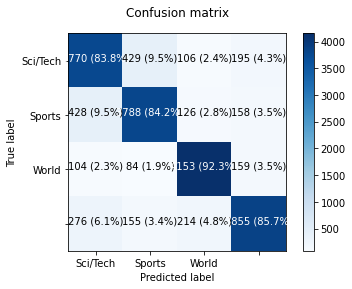

In [39]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#  Figure
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Axis
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()

# Values
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]:d} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

## Prediction

In [40]:
from collections import Counter

In [41]:
class ConvOutputsModel(Model):
    def __init__(self, vocab_size, embedding_dim,
                 filter_sizes, num_filters):
        super(ConvOutputsModel, self).__init__()

        # Embeddings
        self.embedding = Embedding(input_dim=vocab_size,
                                   output_dim=embedding_dim)

        # Conv & pool
        self.convs = []
        for filter_size in filter_sizes:
            conv = Conv1D(filters=num_filters, kernel_size=filter_size,
                          padding='same', activation='relu')
            self.convs.append(conv)

    def call(self, x_in, training=False):
        """Forward pass."""

        # Embed
        x_emb = self.embedding(x_in)

        # Conv
        convs = []
        for i in range(len(self.convs)):
            z = self.convs[i](x_emb)
            convs.append(z)

        return convs

    def summary(self, input_shape):
        x_in = Input(shape=input_shape, name='X')
        summary = Model(inputs=x_in, outputs=self.call(x_in), name=self.name)
        return summary

In [42]:
text = input("Enter text to classify: ")

Enter text to classify: The Canadian government officials proposed the new federal law.


In [43]:
# Create prediction dataset generator
X = np.array(X_tokenizer.texts_to_sequences([text]))
preprocessed_texts = X_tokenizer.sequences_to_texts(X)
y_filler = np.array([0]*len(X))
generator = DataGenerator(
    X=X, y=y_filler, batch_size=batch_size,
    max_filter_size=max(filter_sizes))

In [44]:
# Conv outputs model
conv_outputs_model = ConvOutputsModel(
    vocab_size=vocab_size, embedding_dim=embedding_dim, 
    filter_sizes=filter_sizes, num_filters=num_filters)

In [45]:
# Predict
results = []
y_prob = model.predict(x=generator, verbose=1)
conv_outputs = conv_outputs_model.predict(x=generator, verbose=1)

1/1 [==============================] - 0s 852us/step


In [46]:
# Probability distribution
prob_dist = {}
for i, class_ in enumerate(classes):
    prob_dist[class_] = np.float64(y_prob[0][i])
prob_dist = {k: v for k, v in sorted(
    prob_dist.items(), key=lambda item: item[1], reverse=True)}

In [47]:
# Process conv outputs for each unique filter size
n_grams = {}
tokens = preprocessed_texts[0].split(' ')
for i, filter_size in enumerate(filter_sizes):

    # Identify most important n-gram for each filter's output
    popular_indices = Counter(
        np.argmax(conv_outputs[i][0], axis=0))

    # Get corresponding text
    start = popular_indices.most_common(2)[-1][0]
    end = min(len(tokens), start+filter_size)
    n_gram = " ".join([token for token in tokens[start:end]])
    n_grams[filter_size] = {
        'n_gram': n_gram,
        'start': np.float64(start),
        'end': np.float64(end)
        }

In [48]:
print ('raw_input:', text)
print ('preprocessed_input:', preprocessed_texts[0])
print ('probabilities:\n', json.dumps(prob_dist, indent=2))
print ('top_n_grams:\n', json.dumps(n_grams, indent=2))

raw_input: The Canadian government officials proposed the new federal law.
preprocessed_input: the canadian government officials proposed the new federal law
probabilities:
 {
  "World": 0.6694431304931641,
  "Sci/Tech": 0.17240720987319946,
  "Business": 0.1531640589237213,
  "Sports": 0.004985610023140907
}
top_n_grams:
 {
  "2": {
    "n_gram": "federal law",
    "start": 7.0,
    "end": 9.0
  },
  "3": {
    "n_gram": "new federal law",
    "start": 6.0,
    "end": 9.0
  },
  "4": {
    "n_gram": "federal law",
    "start": 7.0,
    "end": 9.0
  }
}


---
Learn, explore and build at <a href="https://madewithml.com/">Made With ML</a>.

<div align="left">
<a class="ai-header-badge" target="_blank" href="https://github.com/madewithml/basics"><img src="https://img.shields.io/github/stars/madewithml/basics.svg?style=social&label=Star"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.youtube.com/channel/UCaVCnFQXS7PYMoYZu3KdC0Q?sub_confirmation=1"><img src="https://img.shields.io/badge/style--5eba00.svg?label=YouTube&logo=youtube&style=social"></a>&nbsp;<a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml"><img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social"></a>
</div>
             